## Pretraining experiment

Let's experiment with pre-training the embedding networks in the code_search example. 


In [1]:

import csv
from six import StringIO
import tempfile

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import text_problems
from tensor2tensor.utils import metrics

import tensorflow as tf

import tk

from tk.models import similarity_transformer

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


## Base problem

In [2]:

@registry.register_problem
class GithubFunctionDocstring(text_problems.Text2TextProblem):
  """Function and Docstring similarity Problem.
  This problem contains the data consisting of function
  and docstring pairs as CSV files. The files are structured
  such that they contain two columns without headers containing
  the docstring tokens and function tokens. The delimiter is
  ",".
  """

  DATA_PATH_PREFIX = "gs://kubeflow-examples/t2t-code-search/raw_data"

  @property
  def pair_files_list(self):
    """Return URL and file names.
    This format is a convention across the Tensor2Tensor (T2T)
    codebase. It should be noted that the file names are currently
    hardcoded. This is to preserve the semantics of a T2T problem.
    In case a change of these values is desired, one must subclass
    and override this property.
    # TODO(sanyamkapoor): Manually separate train/eval data set.
    Returns:
      A list of the format,
        [
          [
            "STRING",
            ("STRING", "STRING", ...)
          ],
          ...
        ]
      Each element is a list of size 2 where the first represents
      the source URL and the next is an n-tuple of file names.
      In this case, the tuple is of size 1 because the URL points
      to a file itself.
    """
    return [
        [
            "{}/func-doc-pairs-000{:02}-of-00100.csv".format(
                self.DATA_PATH_PREFIX, i),
            ("func-doc-pairs-000{:02}-of-00100.csv".format(i),)
        ]
        for i in range(1)
    ]

  @property
  def is_generate_per_split(self):
    return False

  @property
  def approx_vocab_size(self):
    return 2**13

  @property
  def max_samples_for_vocab(self):
    # FIXME(sanyamkapoor): This exists to handle memory explosion.
    return int(2e5)

  def get_csv_files(self, _data_dir, tmp_dir, _dataset_split):
    return [
        generator_utils.maybe_download(tmp_dir, file_list[0], uri)
        for uri, file_list in self.pair_files_list
    ]

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    """A generator to return data samples.Returns the data generator to return.
    Args:
      data_dir: A string representing the data directory.
      tmp_dir: A string representing the temporary directory and is
              used to download files if not already available.
      dataset_split: Train, Test or Eval.
    Yields:
      Each element yielded is of a Python dict of the form
        {"inputs": "STRING", "targets": "STRING", "embed_code": [0]}
    """
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, function_tokens in reader:
            yield {
                "inputs": docstring_tokens,
                "targets": function_tokens,
                "embed_code": [0]
            }

  def example_reading_spec(self):
    data_fields, data_items_to_decoders = super(GithubFunctionDocstring,
                                                self).example_reading_spec()
    data_fields["embed_code"] = tf.FixedLenFeature([1], dtype=tf.int64)

    data_items_to_decoders = {
      "inputs": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="inputs"),
      "targets": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="targets"),
      "embed_code": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="embed_code")
    }
    return data_fields, data_items_to_decoders

  def eval_metrics(self):  # pylint: disable=no-self-use
    return [
        metrics.Metrics.ACC
    ]


## Pretraining problems

In [3]:
import numpy as np

In [12]:

def _random_mask_sequence(sequence):
  """'quick brown fox' -> 'quick ##### fox'"""
  arr = sequence.split()
  ind = np.random.randint(len(arr))
  arr[ind] = ''.join(["#" for _ in range(0, len(arr[ind]))])
  return ' '.join(arr)


@registry.register_problem
class GithubStringInpaint(GithubFunctionDocstring):
  """Predict full string from truncated string."""

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, _ in reader:

            example = {
                "inputs": _random_mask_sequence(docstring_tokens),
                "targets": docstring_tokens,
                "embed_code": [0]
            }

            yield example


@registry.register_problem
class GithubCodeInpaint(GithubFunctionDocstring):
  """Code in-painting given randomly ablated regions."""

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for _, function_tokens in reader:

            example = {
                "inputs": _random_mask_sequence(function_tokens),
                "targets": function_tokens,
                "embed_code": [0]
            }

            yield example


In [6]:
tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
string_inpaint_problem = GithubStringInpaint()
string_inpaint_problem.generate_data(data_dir, tmp_dir)
code_inpaint_problem = GithubCodeInpaint()
code_inpaint_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Found vocab file: /mnt/nfs-east1-d/data/vocab.github_string_inpaint.8192.subwords


[2018-10-13 19:31:08,006] Found vocab file: /mnt/nfs-east1-d/data/vocab.github_string_inpaint.8192.subwords


INFO:tensorflow:Skipping generator because outputs files exist


[2018-10-13 19:31:08,079] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-10-13 19:31:08,086] Skipping shuffle because output files exist


INFO:tensorflow:Found vocab file: /mnt/nfs-east1-d/data/vocab.github_code_inpaint.8192.subwords


[2018-10-13 19:31:08,089] Found vocab file: /mnt/nfs-east1-d/data/vocab.github_code_inpaint.8192.subwords


INFO:tensorflow:Skipping generator because outputs files exist


[2018-10-13 19:31:08,157] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-10-13 19:31:08,163] Skipping shuffle because output files exist


## Pretraining models

In [7]:

from tensor2tensor.models.transformer import Transformer
from tk.models.similarity_transformer import similarity_cost


@registry.register_model
class SimilarityTransformerPTStringEncoding(Transformer):

  def encode(self, inputs, target_space, hparams, features=None, losses=None):
    with tf.variable_scope("string_encoder"):
      return super(SimilarityTransformerPTStringEncoding, self).encode(
          inputs, target_space, hparams, features, losses)

  def decode(self, decoder_input, encoder_output, encoder_decoder_attention_bias,
             decoder_self_attention_bias, hparams, cache=None, nonpadding=None,
             losses=None):
    with tf.variable_scope("string_decoder"):
      return super(SimilarityTransformerPTStringEncoding, self).decode(
          decoder_input, encoder_output, encoder_decoder_attention_bias,
          decoder_self_attention_bias, hparams, cache, nonpadding,
          losses)


@registry.register_model
class SimilarityTransformerPTCodeEncoding(Transformer):
    
  def encode(self, inputs, target_space, hparams, features=None, losses=None):
    with tf.variable_scope("code_encoder"):
      return super(SimilarityTransformerPTCodeEncoding, self).encode(
          inputs, target_space, hparams, features, losses)

  def decode(self, decoder_input, encoder_output, encoder_decoder_attention_bias,
             decoder_self_attention_bias, hparams, cache=None, nonpadding=None,
             losses=None):
    with tf.variable_scope("code_decoder"):
      return super(SimilarityTransformerPTCodeEncoding, self).decode(
          decoder_input, encoder_output, encoder_decoder_attention_bias,
          decoder_self_attention_bias, hparams, cache, nonpadding,
          losses)


@registry.register_model
class SimilarityTransformerDev(Transformer):

  def encode_string(self, inputs, features=None, losses=None):
    hparams = self._hparams
    target_space = problem.SpaceID.EN_TOK
    with tf.variable_scope("string_encoder"):
      encoder_output, _ = super(SimilarityTransformerDev, self).encode(
          inputs, target_space, hparams, features, losses)
      return tf.reduce_mean(encoder_output, axis=1)

  def encode_code(self, inputs, features=None, losses=None):
    hparams = self._hparams
    target_space = problem.SpaceID.EN_TOK
    with tf.variable_scope("code_encoder"):
      encoder_output, _ = super(SimilarityTransformerDev, self).encode(
          inputs, target_space, hparams, features, losses)
      return tf.reduce_mean(encoder_output, axis=1)

  def body(self, features):
    string_embedding = self.encode_string(features["inputs"])
    code_embedding = self.encode_code(features["targets"])
    loss = self.similarity_cost(string_embedding, code_embedding)    
    return string_embedding, {"training": loss}

  def similarity_cost(self, a, b):
    loss_variant = self.hparams.loss_variant
    return similarity_cost(a, b, loss_variant)

  def infer(self, features=None, **kwargs):
    del kwargs
    if "targets" not in features:
      features["targets"] = tf.zeros_like(features["inputs"])
    predictions, _ = self(features)
    return predictions

@registry.register_model
class SimilarityTransformerStringEncoder(SimilarityTransformerDev):
  """String encoder model restricted to string encoding branch."""

  def body(self, features):
    return self.encode_string(features["inputs"]), {"training": 0.0}


@registry.register_model
class SimilarityTransformerCodeEncoder(SimilarityTransformerDev):
  """Code encoder model restricted to code encoding branch."""

  def body(self, features):
    return self.encode_code(features["inputs"]), {"training": 0.0}


In [8]:

def test_train(problem_object, mfunc):
    
    hparams = similarity_transformer.similarity_transformer_tiny()
    hparams.data_dir = data_dir

    p_hparams = problem_object.get_hparams(hparams)

    model = mfunc(hparams, tf.estimator.ModeKeys.TRAIN, p_hparams)

    batch_size = 1
    train_dataset = problem_object.dataset(Modes.TRAIN, data_dir)
    train_dataset = train_dataset.repeat(None).batch(batch_size)

    optimizer = tf.train.AdamOptimizer()

    @tfe.implicit_value_and_gradients
    def loss_fn(features):
      _, losses = model(features)
      return losses["training"]

    NUM_STEPS = 10

    for count, example in enumerate(tfe.Iterator(train_dataset)):
      loss, gv = loss_fn(example)
      optimizer.apply_gradients(gv)

      if count % 1 == 0:
       print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
      if count >= NUM_STEPS:
       break


In [9]:
test_train(string_inpaint_problem, SimilarityTransformerPTStringEncoding)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-13 19:30:28,053] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_string_inpaint-train*


[2018-10-13 19:30:28,056] Reading data files from /mnt/nfs-east1-d/data/github_string_inpaint-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-13 19:30:28,071] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8678_128.bottom


[2018-10-13 19:30:28,368] Transforming feature 'inputs' with symbol_modality_8678_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8678_128.targets_bottom


[2018-10-13 19:30:28,434] Transforming 'targets' with symbol_modality_8678_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-13 19:30:28,440] Building model body


INFO:tensorflow:Transforming body output with symbol_modality_8678_128.top


[2018-10-13 19:30:28,602] Transforming body output with symbol_modality_8678_128.top


Step: 0, Loss: 8.469
Step: 1, Loss: 8.375
Step: 2, Loss: 8.077
Step: 3, Loss: 7.903
Step: 4, Loss: 7.895
Step: 5, Loss: 7.894
Step: 6, Loss: 7.892
Step: 7, Loss: 7.960
Step: 8, Loss: 7.030
Step: 9, Loss: 7.439
Step: 10, Loss: 7.007


In [9]:
test_train(code_inpaint_problem, SimilarityTransformerPTCodeEncoding)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-13 19:30:47,030] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_code_inpaint-train*


[2018-10-13 19:30:47,034] Reading data files from /mnt/nfs-east1-d/data/github_code_inpaint-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-13 19:30:47,047] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8216_128.bottom


[2018-10-13 19:30:47,251] Transforming feature 'inputs' with symbol_modality_8216_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8216_128.targets_bottom


[2018-10-13 19:30:47,360] Transforming 'targets' with symbol_modality_8216_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-13 19:30:47,366] Building model body


INFO:tensorflow:Transforming body output with symbol_modality_8216_128.top


[2018-10-13 19:30:47,589] Transforming body output with symbol_modality_8216_128.top


Step: 0, Loss: 8.063
Step: 1, Loss: 8.031
Step: 2, Loss: 7.606
Step: 3, Loss: 7.603
Step: 4, Loss: 7.843
Step: 5, Loss: 8.285
Step: 6, Loss: 6.998
Step: 7, Loss: 8.000
Step: 8, Loss: 8.087
Step: 9, Loss: 7.011
Step: 10, Loss: 7.257


In [9]:
tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
similarity_problem = GithubFunctionDocstring()
similarity_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Found vocab file: /mnt/nfs-east1-d/data/vocab.github_function_docstring.8192.subwords


[2018-10-13 19:31:10,404] Found vocab file: /mnt/nfs-east1-d/data/vocab.github_function_docstring.8192.subwords


INFO:tensorflow:Skipping generator because outputs files exist


[2018-10-13 19:31:10,467] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-10-13 19:31:10,474] Skipping shuffle because output files exist


In [10]:
test_train(similarity_problem, SimilarityTransformerDev)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-13 19:31:11,724] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


[2018-10-13 19:31:11,727] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-13 19:31:11,739] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8185_128.bottom


[2018-10-13 19:31:11,937] Transforming feature 'inputs' with symbol_modality_8185_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8185_128.targets_bottom


[2018-10-13 19:31:12,087] Transforming 'targets' with symbol_modality_8185_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-13 19:31:12,093] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-13 19:31:12,231] Skipping T2TModel top and loss because training loss returned from body


Step: 0, Loss: 0.797
Step: 1, Loss: 0.515
Step: 2, Loss: 0.422
Step: 3, Loss: 0.377
Step: 4, Loss: 0.367
Step: 5, Loss: 0.363
Step: 6, Loss: 0.356
Step: 7, Loss: 0.349
Step: 8, Loss: 0.335
Step: 9, Loss: 0.341
Step: 10, Loss: 0.332


## Test infer

Test run inference with similarity transformer model - for testing, not actual inference.

In [13]:

mfunc = SimilarityTransformerDev
hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = "/mnt/nfs-east1-d/data"
p_hparams = similarity_problem.get_hparams(hparams)
model = mfunc(hparams, tf.estimator.ModeKeys.TRAIN, p_hparams)


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-13 17:13:46,722] Setting T2TModel mode to 'train'


In [16]:

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None, encoders=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}


In [15]:

query = "hello world"
encoders = similarity_problem.feature_encoders(hparams.data_dir)
encoded = encode(query, encoders=encoders)


In [16]:
model.infer(encoded)

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8185_128.bottom


[2018-10-13 17:13:48,646] Transforming feature 'inputs' with symbol_modality_8185_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8185_128.targets_bottom


[2018-10-13 17:13:48,702] Transforming 'targets' with symbol_modality_8185_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-13 17:13:48,709] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-13 17:13:48,833] Skipping T2TModel top and loss because training loss returned from body


<tf.Tensor: id=1791, shape=(1, 128), dtype=float32, numpy=
array([[ 1.40312207e+00,  4.11589928e-02,  2.35747501e-01,
        -1.88300814e-02, -1.07104623e+00, -9.13565531e-02,
        -1.05973817e-01, -9.50440705e-01,  1.77466944e-01,
        -1.50291741e+00, -1.07418168e+00,  8.26738656e-01,
        -9.26443577e-01,  7.28578806e-01,  1.04180527e+00,
        -3.22116613e-01, -9.49340522e-01, -9.88778055e-01,
         9.05352890e-01,  5.52978933e-01, -1.73431015e+00,
        -2.17968181e-01,  8.49038780e-01,  5.11551857e-01,
        -3.42293590e-01, -9.81901467e-01, -5.03470659e-01,
        -1.67851782e+00,  4.10288692e-01,  9.97195765e-02,
        -7.52441883e-01, -5.39046288e-01, -2.23350406e-01,
        -7.07565248e-01, -6.44576609e-01,  1.06538534e-01,
        -6.71832621e-01, -1.13049018e+00,  6.00363910e-01,
        -1.72126734e+00, -1.34397602e+00, -9.84495655e-02,
        -1.00991380e+00, -1.04756880e+00, -7.60911778e-02,
         3.73768806e-01, -4.25622553e-01, -1.66359270e+0

test run encoder models

In [10]:

mfunc = SimilarityTransformerStringEncoder
hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = "/mnt/nfs-east1-d/data"
p_hparams = similarity_problem.get_hparams(hparams)
model = mfunc(hparams, tf.estimator.ModeKeys.TRAIN, p_hparams)


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-13 17:28:38,894] Setting T2TModel mode to 'train'


In [14]:

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None, encoders=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}


In [15]:

query = "hello world"
encoders = similarity_problem.feature_encoders(hparams.data_dir)
encoded = encode(query, encoders=encoders)


In [16]:
model(encoded)

(<tf.Tensor: id=1539, shape=(1, 128), dtype=float32, numpy=
 array([[ 0.20939891,  1.4125671 , -1.1328112 , -0.3512763 , -0.41080883,
          1.3939236 , -0.10723416,  0.02681199, -0.40401328,  0.2177443 ,
         -0.5391284 , -0.28195366,  0.3392299 ,  1.1051393 , -0.9326196 ,
          0.98122907, -0.2839588 ,  0.57894486, -0.06313259,  0.13741706,
         -0.5806601 , -1.1774725 , -0.06144382, -0.39439023, -0.43148208,
          0.54337835, -0.21367322, -0.05622693, -0.8115094 , -0.00709867,
         -1.4922934 , -0.3881702 , -1.0974838 , -0.04772195,  0.2919239 ,
         -0.47904715,  0.6601294 , -0.8428251 ,  0.25696883,  0.02348729,
         -0.42546833, -0.97120833,  1.4458374 , -1.3749505 , -1.4001378 ,
          0.27956572, -0.21210705, -1.6437635 , -1.161673  , -1.9406843 ,
         -0.67711157, -0.6752469 , -0.16725959,  0.4377724 , -0.48400614,
         -1.2816873 , -1.1917607 , -0.93713236,  0.54529124, -0.5790736 ,
         -0.6249497 ,  0.4583448 , -0.48818526, -0.0

## Training test runs

In [1]:

from tk.experiment import configure_experiment, T2TExperiment
from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline


In [19]:

args = configure_experiment("cs-pt-str-0",
                             problem="github_string_inpaint",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_pretrain_string_encoding",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_pretrain_string_encoding',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'github_string_inpaint',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [20]:

args = configure_experiment("cs-pt-fn-0",
                             problem="github_code_inpaint",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_pretrain_code_encoding",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_pretrain_code_encoding',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'github_code_inpaint',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-13 20:17:11,467] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-10-13 20:17:12,514] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-10-13 20:17:13,667] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-13 20:17:14,647] Finished loading event data for comparison.


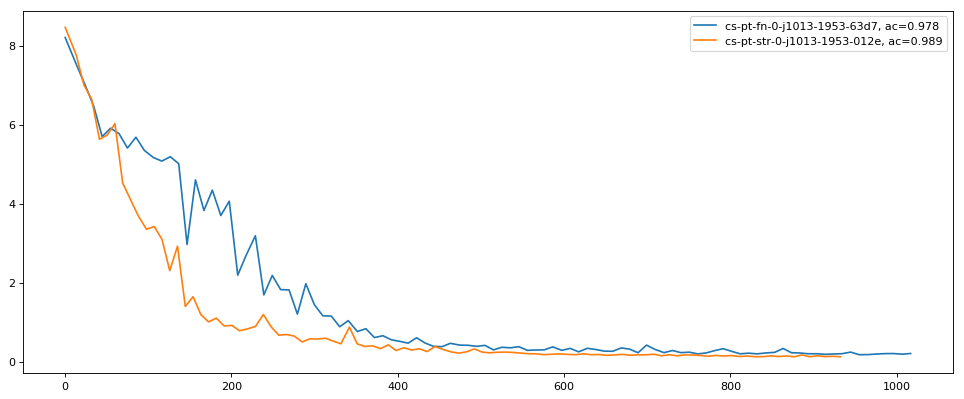

In [1]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-pt*")
show_experiment_loss(experiment_data)


From the above we can see both types of pre-training are showing healthy loss curves and seem to saturate by 10k steps. But let's confirm that by looking at some inference examples.

Next we'll copy the checkpoint to a new path so we can avoid modifying the original in subsequent experiments

In [ ]:
!gsutil -m cp -r gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-j1013-1953-012e/output \
    gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-restore/output

In [ ]:
!gsutil -m cp -r gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-j1013-1953-012e/output \
    gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-xfer/output

In [ ]:
!gsutil -m cp -r gs://kubeflow-rl-checkpoints/comparisons/cs-pt-fn-0/cs-pt-fn-0-j1013-1953-63d7/output \
    gs://kubeflow-rl-checkpoints/comparisons/cs-pt-fn-0/cs-pt-fn-0-xfer/output

Let's try a training run that uses a previous set of checkpoints of the same type:

In [13]:

args = configure_experiment("cs-pt-str-restore",
                             problem="github_string_inpaint",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_pretrain_string_encoding",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=11000,
                             reuse_output_dir="gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-restore/output")

job = T2TExperiment(**args)
job.run()


[2018-10-13 23:23:01,726] /mnt/nfs-east1-d/work/tk
[2018-10-13 23:23:01,752] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_pretrain_string_encoding',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-restore/output',
 'problem': 'github_string_inpaint',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-restore/cs-pt-str-restore-j1013-2323-4844/tk',
 'train_steps': 11000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-13 23:23:09,500] smoke: True


Or different type

In [17]:

args = configure_experiment("cs-pt-fn-post-str",
                             problem="github_code_inpaint",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_pretrain_code_encoding",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=20000,
                             reuse_output_dir="gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-xfer/output")

job = T2TExperiment(**args)
job.run()


[2018-10-13 23:28:09,534] /mnt/nfs-east1-d/work/tk
[2018-10-13 23:28:09,575] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_pretrain_code_encoding',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-pt-str-0/cs-pt-str-0-xfer/output',
 'problem': 'github_code_inpaint',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-pt-fn-post-str/cs-pt-fn-post-str-j1013-2328-84f5/tk',
 'train_steps': 20000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-13 23:28:17,419] smoke: True


Taking another look at the loss plots:

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-13 22:42:57,850] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 5)


[2018-10-13 22:42:58,976] Processing experiment events (1 of 5)


INFO:tensorflow:Processing experiment events (2 of 5)


[2018-10-13 22:43:00,183] Processing experiment events (2 of 5)


INFO:tensorflow:Processing experiment events (3 of 5)


[2018-10-13 22:43:01,070] Processing experiment events (3 of 5)


INFO:tensorflow:Processing experiment events (4 of 5)


[2018-10-13 22:43:01,931] Processing experiment events (4 of 5)


INFO:tensorflow:Processing experiment events (5 of 5)


[2018-10-13 22:43:02,739] Processing experiment events (5 of 5)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-13 22:43:03,606] Finished loading event data for comparison.


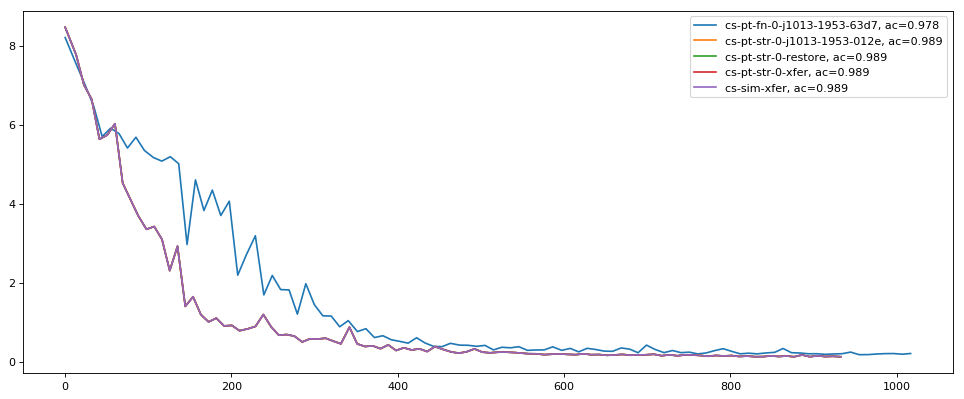

In [2]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-pt*")
show_experiment_loss(experiment_data)


Had to increase num steps to be previous + additional not just additional.

Ah. So. It uses the model name in the variable name path. So probably need to use a single model that changes modes based on hparams or content of example dicts.

What if we just named the model the same?

Ultimately not as fond of the traditional multi-step pre-training approach as a continuous multi-problem approach.